Length scale associated with flow
===
The Advection-Diffusion problem we're solving is $\vec v \cdot \nabla c=\eta \nabla^2 c$. The diffusion coefficient, $\eta$, has dimensions of Length$^2$/Time. The gradient of the velocity field has dimensions of 1/Time, which means that $\sqrt{\eta/\nabla v}$ has dimensions of Length, and it is a relevant lengthscale in the problem. The purpose of this notebook is to demonstrate that.

Since $\nabla v$ is a tensor (2-rank), we need to extract a scalar from it. Here we'll use the eigenvalues of its symmetric form $\nabla v+\nabla v^T$, but other scalars can also be used (say, the norm). Also, note that the lengthscale is a property of the velocity field, not of the steady-state solution for the plume (which also depends on the location of the sources and such)

First, define all the needed functions:

In [2]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from scipy.integrate import ode
from mpl_toolkits.axes_grid1 import make_axes_locatable

mrand=lambda: 2*np.random.rand()-1 # shortcut random number between -1 and 1
N=100

def roll(arr,tup):
    '''a shortcut. roll(arr,(S1,S2)) applies roll with S1 steps on 1st axis and then with S2 on the 2nd one'''
    return np.roll(np.roll(arr,tup[0],axis=0),tup[1],axis=1)
import numpy as np
from numpy import pi
from scipy.integrate import ode

mrand=lambda: 2*np.random.rand()-1 # shortcut random number between -1 and 1
def roll(arr,tup):
    '''a shortcut. roll(arr,(S1,S2)) applies roll with S1 steps on 1st axis and then with S2 on the 2nd one'''
    return np.roll(np.roll(arr,tup[0],axis=0),tup[1],axis=1)

def generate_v_field(n=17,max_periods=4):
    '''Generates a random divergence-less velocity field on the periodic domain [0,2*pi]x[0,2*pi].
       n - number of sinusoidal terms
       max_periods - maximal periods each term has over the domain 2pi (large value = high frequency)
    '''
    x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],
                    np.linspace(0,2*pi,N+1)[:-1])
    u=0*x;
    v=0*x;
    for i in xrange(n):
        A=np.random.randn()
        nx=np.round(max_periods*mrand())
        ny=np.round(max_periods*mrand())
        phi=pi*mrand()
        u+=A*ny*np.sin(nx*x+ny*y+phi)
        v-=A*nx*np.sin(nx*x+ny*y+phi)
    return u,v

def velocity_dot_grad_c(u,v,C):
    '''calculates the advective derivative of C with the velocity field (u,v)/
       That is, u dC/dx+v dC/dy'''
    
    return  (
            (0.25/dx)*(
             (C+roll(C,[0,-1]))*(roll(u,[1,-1])+roll(u,[0,-1]))-
             (C+roll(C,[0, 1]))*(roll(u,[0, 0])+roll(u,[1, 0])))+
            (0.25/dx)*(
             (C+roll(C,[-1, 0]))*(roll(v,[0,0])+roll(v,[0,-1]))-
             (C+roll(C,[ 1, 0]))*(roll(v,[1,-1])+roll(v,[1,0])))
            )

def laplacian(C):
    '''calculates the laplacian of C'''
    return (
            roll(C,[-1,0])+roll(C,[0,-1])+roll(C,[1,0])+roll(C,[0,1])-4*C
            )/(dx**2)

def dvdt_maker(u,v,eta,sources):
    '''returns a function that calculates the time derivative but is usable in the integrator that needs a vector
       input rather than a matrix.'''
    return lambda t,C: Cdot(C.reshape(N,N),u,v,eta,sources).flatten()

def Cdot(C,u,v,eta,sources):
    '''Returns the time derivative of the concentration field C, under diffusion and advection
       C        - concentration field
       (u,v)    - components of velocity field
       eta      - diffusion constant
       sources  - sources (and sinks)'''
    return -velocity_dot_grad_c(u,v,C)+eta*laplacian(C)+sources

def point_sources():
    z=np.zeros([N,N])
    z[np.round(N/4),np.round(N/4)]=1
    z[np.round(3*N/4),np.round(3*N/4)]=-1
    return z

def gauss_sources(width=0.2,randomize_positions=False):
    x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],
                np.linspace(0,2*pi,N+1)[:-1])
    q=np.exp(-((x-pi)/width)**2-((y-pi)/width)**2)

    if randomize_positions:
        return roll(q,[int(N*mrand()) for i in [1,2]])-roll(q,[int(N*mrand()) for i in [1,2]])
    else:
        return roll(q,[N/4,N/4])-roll(q,[-N/4,-N/4])

def calculate_steady_plume(eta,
                           number_of_points=200,
                           tolerance=1.0e-8,
                           max_iterations=100,
                           verbose=False,
                           width=0.2,
                           randomize_positions=False,
                           timestep=1,
                           seed='auto'):
    '''
        Calculates a steady plume in a divergenceless field. 
        Returns (c,u,v,sources,flag, errors):
            c       - the steady concentration field
            (u, v)  - the velocity field
            sources - the sources and sinks in the equation
            flag    - True if the solution is steady to within the tolerance
            errors  - the time evolution of the error (=norm of time derivative). 
                      when error<tolerance the solver stops and exits
        Arguments:
            eta                 - diffusion constant
            number_of_points    - in each dimension (result is an NxN matrix)
            width               - width of the gaussian sources
            randomize_positions - whether to choose the positions of the source and sink randomly
                                  if False, they are at the middle of the top-right and bottom-left quartiles
            verbose             - whether to print progress in each iteration
            timestep            - check if solution has converged every timestep (in simulation time)
            seed                - random seed (must be int, otherwise no explicit seed specified to numpy)
    '''
    global dx, N
    if type(seed)==type(3):
        np.random.seed(seed)
        
    N=number_of_points
    dx=2*pi/N
    u,v=generate_v_field()
    sources=gauss_sources(randomize_positions=randomize_positions,width=width)
    fdot=dvdt_maker(u,v,eta,sources)
    
    solver=ode(fdot).set_integrator('dopri5')
    solver.set_initial_value(0*u.flatten())
    i=0;
    #prev=np.zeros(N*N);
    error=1
    errs=[]
    while solver.successful() and i<max_iterations and error > tolerance:
        solver.integrate(solver.t+timestep)
        error=(dx**2)*np.sum(np.abs(fdot(0,solver.y)))
        #prev=solver.y
        errs.append(error)
        i+=1
        if verbose:
            print 'step %d, error=%e' %(i, error)
    return (solver.y.reshape(N,N), u, v,  sources, error<tolerance ,errs)

def eigen(x,y,od):
    '''returns the two eigenvalues and principal direction (in rads) of the matrix ([[x, od], [od, y]])'''
    disc=np.sqrt((ux-vy)**2 + 4*(od**2))
    ev1=(ux + vy - disc)/2
    ev2=(ux + vy + disc)/2
    ang=np.arctan2(2*od,ux - vy - disc)
    return ev1, ev2, ang

Generate velocity field and calculate steady-state plume

In [ ]:
N=250
res=calculate_steady_plume(0.1,number_of_points=N,verbose=False,tolerance=1e-2,seed=4113, timestep=0.1,max_iterations=1e100)

Calculate the velocity gradient and its eigenvalues

In [4]:
s,u,v=res[:3]
x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],np.linspace(0,2*pi,N+1)[:-1])
npad=10
uy,ux=np.gradient(np.pad(u,npad,'wrap'),x[1,2]-x[1,1]) # Pad the velocity field periodically, to have the graidents 
vy,vx=np.gradient(np.pad(v,npad,'wrap'),x[1,2]-x[1,1]) # correct also on the boundaries
ux,uy,vx,vy=[a[npad:-npad,npad:-npad] for a in [ux,uy,vx,vy]] # chop away the padding
ev1, ev2, ang=eigen(ux,vy,(uy+vx)/2)

Because the velocity field is divergenceless, $\nabla v$ is a traceless tensor, which means that the two eigenvalues are equal in magnitude and have opposite signs. Here's how the eigenvalue change in space:

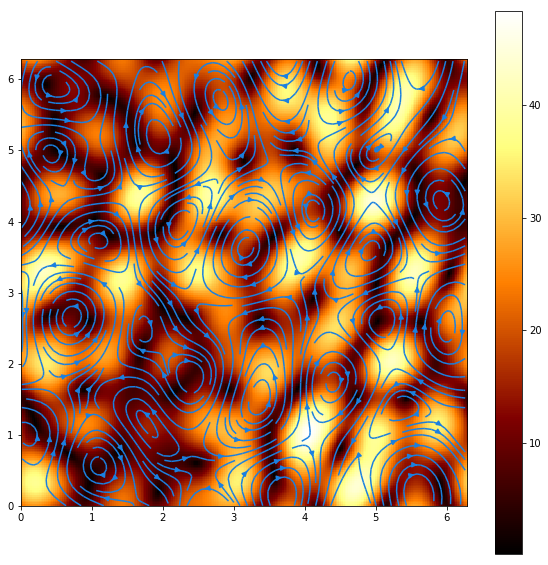

In [22]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(10,10))
cax=ax.imshow(np.abs(ev1),origin='lower',extent=(0,2*pi,0,2*pi),cmap=plt.get_cmap('afmhot'))
ax.streamplot(x,y,u,v,color=[0.1,0.5,0.88],density=2)
fig.colorbar(cax)
plt.show()

Here's how associated lengthscale, which is $\sqrt{\eta/\lambda}$ (where $\lambda$ is the eigenvalue) is distributed in space (note color bar is logarithmic):

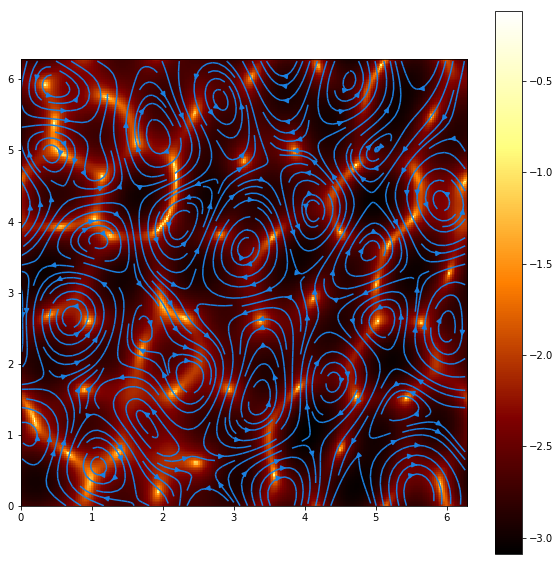

In [25]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(10,10))
cax=ax.imshow(np.log(np.sqrt(np.abs(0.1/ev1))),origin='lower',extent=(0,2*pi,0,2*pi),cmap=plt.get_cmap('afmhot'))
ax.streamplot(x,y,u,v,color=[0.1,0.5,0.88],density=2)
fig.colorbar(cax)
plt.show()

 Maybe a better way to visualize this is to plot circles with the correspoinding radii. On each circle we also plot the eigen directions of the velocity graident

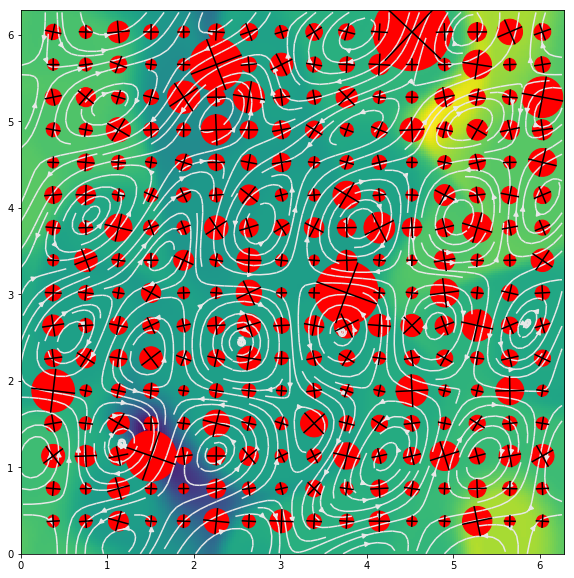

In [47]:
%matplotlib inline
from matplotlib.patches import Circle
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10,10))
plt.imshow(s,origin='lower',extent=(0,2*pi,0,2*pi))
plt.streamplot(x,y,u,v,color=[0.91,0.91,0.91],density=2)
k=15
f=lambda input: np.sqrt(0.1/np.abs(input))
for i in range(k,N,k):#[3*k]:
    for j in range(k,N,k):#[4*k]:
        gv=np.array([[vx[i,j], vy[i,j]],[ux[i,j],uy[i,j]]])
        ls,vs=np.linalg.eigh(gv)
        ax.add_artist(Circle((x[i,j],y[i,j]),f(ev1[i,j]),color='r'))
        ax.plot([x[i,j]-f(ev1[i,j])*np.cos(ang[i,j]), x[i,j]+f(ev1[i,j])*np.cos(ang[i,j])],
                [y[i,j]-f(ev1[i,j])*np.sin(ang[i,j]), y[i,j]+f(ev1[i,j])*np.sin(ang[i,j])],
                'k')
        ax.plot([x[i,j]-f(ev1[i,j])*np.sin(ang[i,j]), x[i,j]+f(ev1[i,j])*np.sin(ang[i,j])],
                [y[i,j]+f(ev1[i,j])*np.cos(ang[i,j]), y[i,j]-f(ev1[i,j])*np.cos(ang[i,j])],
                'k')
ax.set_ylim(0,2*pi)
plt.show()

Here's how this vlaue is distributed over many realizations of velocity fields:

In [32]:
nit=1000
scales=np.zeros([nit,N**2])
for i in range(nit):
    u,v=generate_v_field()
    npad=10
    uy,ux=np.gradient(np.pad(u,npad,'wrap'),x[1,2]-x[1,1]) # Pad the velocity field periodically, to have the graidents 
    vy,vx=np.gradient(np.pad(v,npad,'wrap'),x[1,2]-x[1,1]) # correct also on the boundaries
    ux,uy,vx,vy=[a[npad:-npad,npad:-npad] for a in [ux,uy,vx,vy]] # chop away the padding
    ev1, ev2, ang=eigen(ux,vy,(uy+vx)/2)
    scales[i,:]=np.sqrt(np.abs(0.1/ev1.flatten()))
    

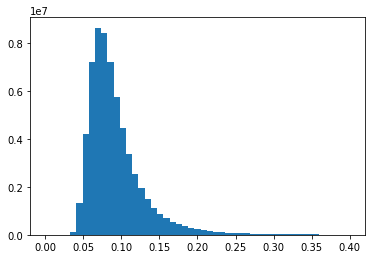

In [38]:
plt.hist(scales.flatten(),np.linspace(0,0.4))
plt.show()

This shows that the typical lengthscale (for $\eta=0.1$) is about 0.07, which means that in order to resolve the domain ($[0\times2\pi]^2$) we need about 100 points per dimension.